In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-09-13 09:02:22.968615: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757754142.991309     519 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757754142.998263     519 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
dataset_Bdir = "/kaggle/input/vd-by-organs/dataset-2"
#loading the dataset
df = pd.read_csv("/kaggle/input/vd-csv-2/Vitamin_Deficiency_Dataset_labels.csv")

df['multilabel'] = df['multilabel'].apply(eval)
all_labels = sorted(set([label for labels in df['multilabel'] for label in labels]))

#binary columns for each label
for label in all_labels:
    df[label] = df['multilabel'].apply(lambda x: 1 if label in x else 0)

# Preview the dataset
print(df.head())

                                         image_path body_part  \
0  Eyes/vitamin_A deficiency/alopecia-areata-24.jpg      Eyes   
1  Eyes/vitamin_A deficiency/alopecia-areata-25.jpg      Eyes   
2  Eyes/vitamin_A deficiency/alopecia-areata-26.jpg      Eyes   
3  Eyes/vitamin_A deficiency/alopecia-areata-27.jpg      Eyes   
4  Eyes/vitamin_A deficiency/alopecia-areata-28.jpg      Eyes   

                vitamin                    multilabel  Eyes  Lips  Nails  \
0  vitamin_A deficiency  [Eyes, vitamin_A deficiency]     1     0      0   
1  vitamin_A deficiency  [Eyes, vitamin_A deficiency]     1     0      0   
2  vitamin_A deficiency  [Eyes, vitamin_A deficiency]     1     0      0   
3  vitamin_A deficiency  [Eyes, vitamin_A deficiency]     1     0      0   
4  vitamin_A deficiency  [Eyes, vitamin_A deficiency]     1     0      0   

   Skin  Tongue  vitamin_A deficiency  vitamin_B complex deficiency  \
0     0       0                     1                             0   
1     0   

In [3]:
# Split data
from sklearn.model_selection import train_test_split
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [4]:
# Data generators
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
     directory=dataset_Bdir,
    x_col="image_path",
    y_col=all_labels,
    target_size=(299, 299),
    batch_size=32,
    class_mode='raw'
)

val_gen = datagen.flow_from_dataframe(
    dataframe=val_df,
     directory=dataset_Bdir,
    x_col='image_path',
    y_col=all_labels,
    target_size=(299, 299),
    batch_size=32,
    class_mode='raw'
)

Found 8748 validated image filenames.
Found 1875 validated image filenames.


In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import InceptionV3
#model
bmodel = InceptionV3(weights='imagenet', include_top=False, input_shape= (299, 299, 3))
bmodel.trainable = False

I0000 00:00:1757754174.522277     519 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1757754174.522964     519 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [6]:
#layers
x = bmodel.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(len(all_labels), activation='sigmoid')(x)

model = Model(inputs=bmodel.input, outputs=predictions)

In [8]:
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [9]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 149, 149,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 149, 149,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 147, 147,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 73, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 73, 73,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 71, 71,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 22,859,054 (87.20 MB)

 Trainable params: 1,056,270 (4.03 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [10]:
r = model.fit(
    train_gen,
    epochs=32,
    validation_data=val_gen
)

test_loss, test_accuracy = model.evaluate(val_gen)
print(f"\nTest Accuracy: {test_accuracy:.2%}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/32


I0000 00:00:1757754211.477564     572 service.cc:148] XLA service 0x7c1690002230 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757754211.477600     572 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1757754211.477604     572 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1757754213.362504     572 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/274 ━━━━━━━━━━━━━━━━━━━━ 1:46:30 23s/step - accuracy: 0.0000e+00 - loss: 0.7533

I0000 00:00:1757754223.035176     572 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


274/274 ━━━━━━━━━━━━━━━━━━━━ 147s 452ms/step - accuracy: 0.8009 - loss: 0.2060 - val_accuracy: 0.9376 - val_loss: 0.1430
Epoch 2/32
274/274 ━━━━━━━━━━━━━━━━━━━━ 74s 269ms/step - accuracy: 0.9134 - loss: 0.1333 - val_accuracy: 0.9253 - val_loss: 0.1390
Epoch 3/32
274/274 ━━━━━━━━━━━━━━━━━━━━ 74s 269ms/step - accuracy: 0.9272 - loss: 0.1219 - val_accuracy: 0.9152 - val_loss: 0.1359
Epoch 4/32
274/274 ━━━━━━━━━━━━━━━━━━━━ 74s 268ms/step - accuracy: 0.9402 - loss: 0.1145 - val_accuracy: 0.9147 - val_loss: 0.1375
Epoch 5/32
274/274 ━━━━━━━━━━━━━━━━━━━━ 74s 268ms/step - accuracy: 0.9426 - loss: 0.1105 - val_accuracy: 0.9312 - val_loss: 0.1288
Epoch 6/32
274/274 ━━━━━━━━━━━━━━━━━━━━ 71s 258ms/step - accuracy: 0.9418 - loss: 0.1064 - val_accuracy: 0.9403 - val_loss: 0.1261
Epoch 7/32
274/274 ━━━━━━━━━━━━━━━━━━━━ 75s 272ms/step - accuracy: 0.9356 - loss: 0.1016 - val_accuracy: 0.9253 - val_loss: 0.1276
Epoch 8/32
274/274 ━━━━━━━━━━━━━━━━━━━━ 79s 287ms/step - accuracy: 0.9530 - loss: 0.0979 - va

In [14]:
y_pred_prob = model.predict(val_gen, verbose=1) 
threshold = 0.5
y_pred = (y_pred_prob >= threshold).astype(int)
y_true = val_df[all_labels].values

59/59 ━━━━━━━━━━━━━━━━━━━━ 26s 330ms/step


In [15]:
print(classification_report(y_true, y_pred, target_names=all_labels, zero_division=0))

                              precision    recall  f1-score   support

                        Eyes       0.29      0.29      0.29       568
                        Lips       0.00      0.00      0.00        61
                       Nails       0.25      0.25      0.25       494
                        Skin       0.38      0.38      0.38       730
                      Tongue       0.00      0.00      0.00        22
        vitamin_A deficiency       0.33      0.29      0.31       684
vitamin_B complex deficiency       0.00      0.00      0.00        82
      vitamin_B12 deficiency       0.11      0.12      0.12       293
       vitamin_B2 deficiency       0.00      0.00      0.00        11
       vitamin_B3 deficiency       0.00      0.00      0.00        33
       vitamin_B9 deficiency       0.03      0.02      0.03        81
        vitamin_C deficiency       0.00      0.00      0.00        19
        vitamin_D deficiency       0.32      0.26      0.29       636
        vitamin_E d

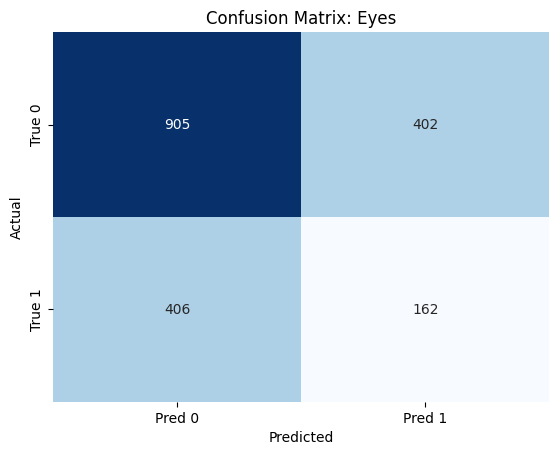

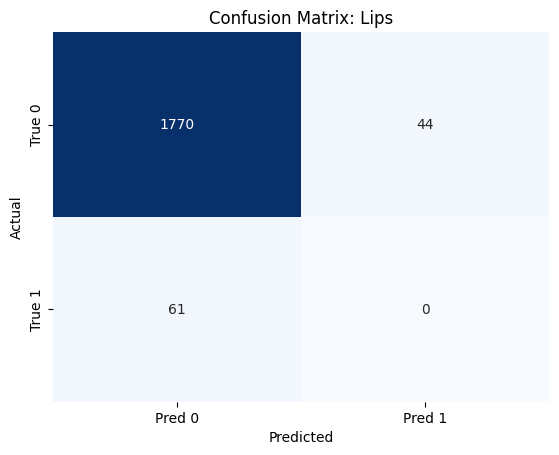

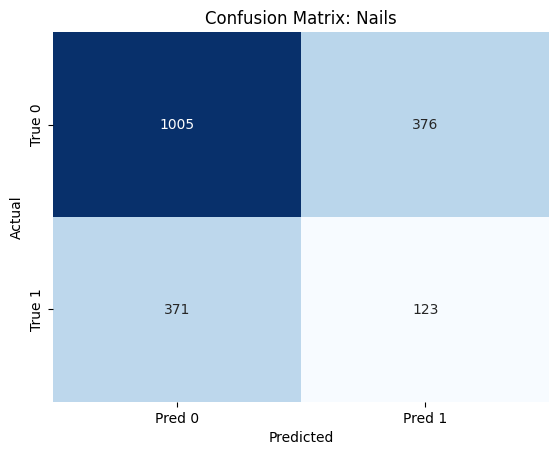

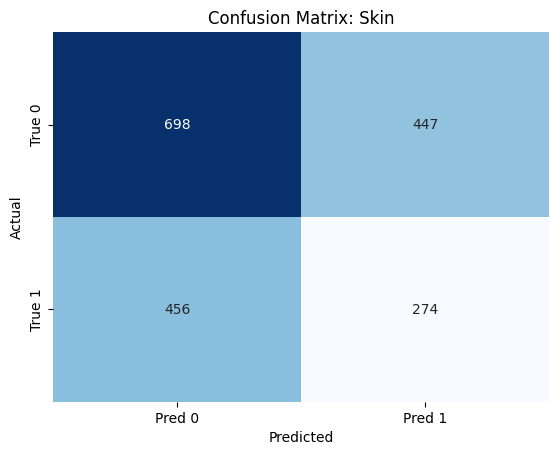

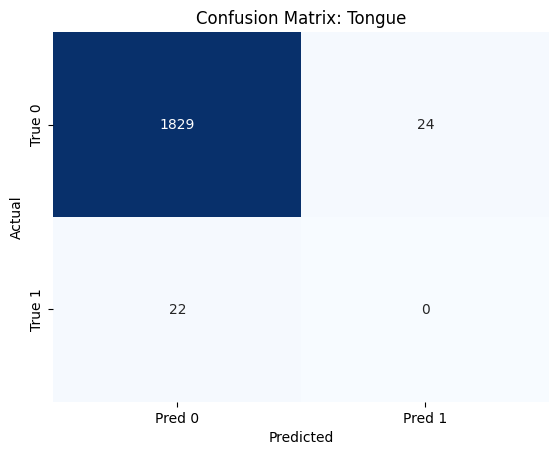

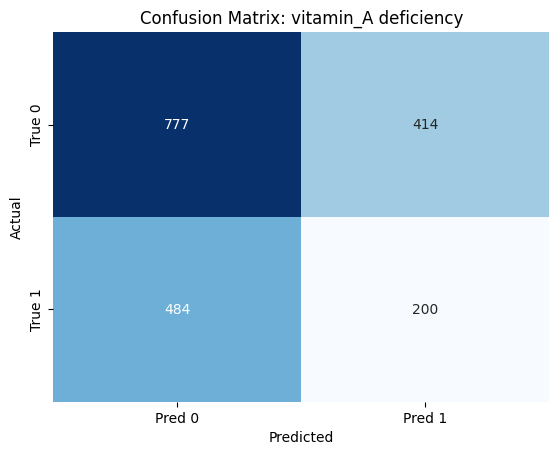

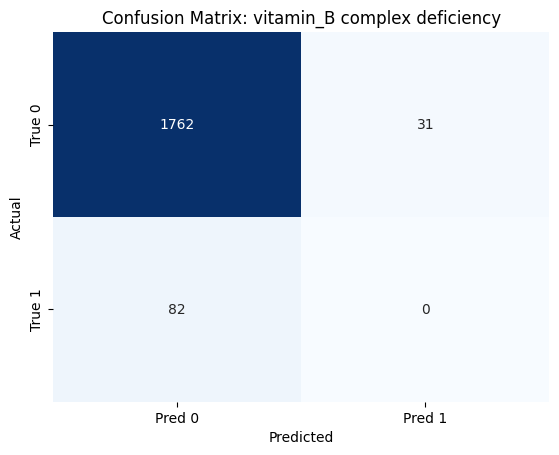

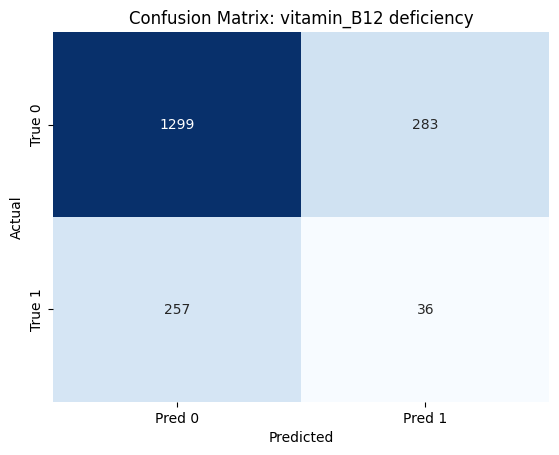

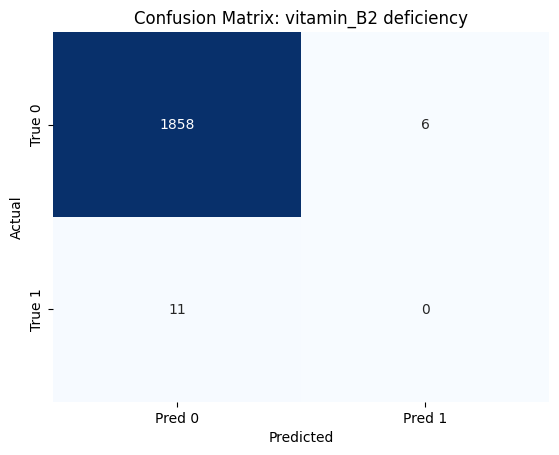

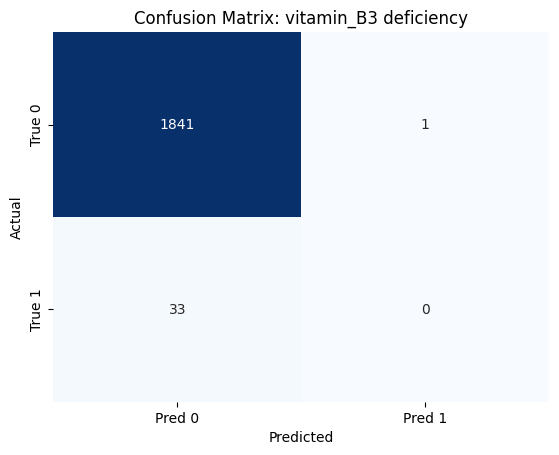

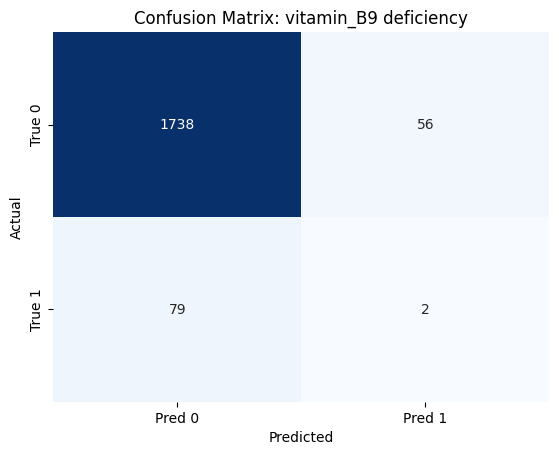

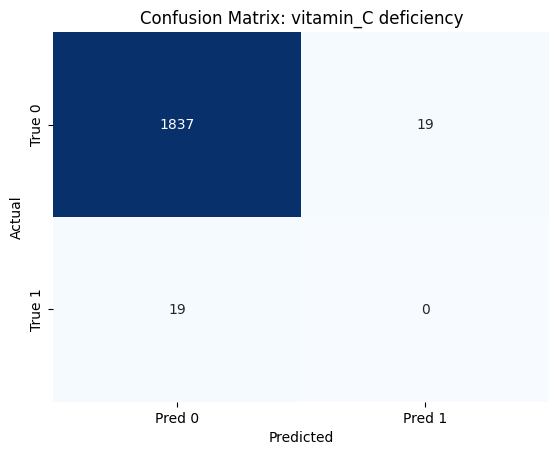

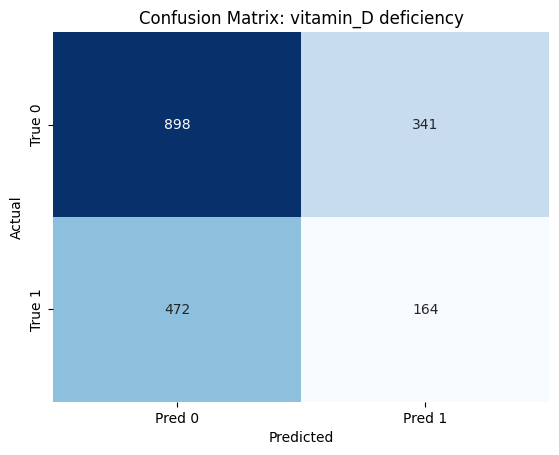

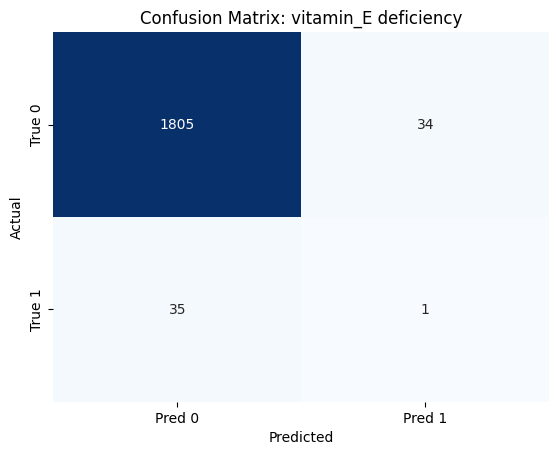

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
mcm = multilabel_confusion_matrix(y_true, y_pred)

# 5) Plot confusion matrix for each class
for i, label in enumerate(all_labels):
    tn, fp, fn, tp = mcm[i].ravel()
    cm = np.array([[tn, fp],
                   [fn, tp]])

    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax,
                xticklabels=["Pred 0", "Pred 1"],
                yticklabels=["True 0", "True 1"])
    ax.set_title(f"Confusion Matrix: {label}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    plt.show()